In [ ]:
# -*- coding: utf-8 -*-
import torch
import numpy as np
import sys, copy, math, time, pdb, warnings, traceback
import pickle
import scipy.io as sio
import scipy.sparse as ssp
import os.path
import random
import argparse
from shutil import copy, rmtree, copytree
from torch.optim.lr_scheduler import ReduceLROnPlateau
from util_functions import *
from preprocessing_Dataset1 import *
from train_eval import *
from models import *
from torch_geometric.data import Data, Dataset
import traceback
import warnings
import sys
import xlwt
from torchsummary import summary
import gc
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score,f1_score,precision_score,recall_score,auc



if __name__ == '__main__':

    # Arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--no-train', action='store_true', default=False)
    parser.add_argument('--dataset', help='dataset name')

    parser.add_argument('--use-features', action='store_true', default=False)

    args = parser.parse_args()

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(2341)
    seed=2341
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark=False
    torch.backends.cudnn.deterministic=True
    hop = 1

    if not args.no_train:
        #Construct model
        print('training.....')
        data_combo = (args.dataset, '', '')
        u_features, v_features, net, labels, u_indices, v_indices, num_list = load_data(args.dataset)
        print('preprocessing end.')
        adj=torch.tensor(net)
        if args.use_features:
            n_features = u_features.shape[1] + v_features.shape[1]
        else:
            u_features, v_features = None, None
            n_features = 0
        all_indices = (u_indices, v_indices)
        print('begin constructing all_graphs')
        all_graphs = extracting_subgraphs(net, all_indices, labels,hop, u_features,v_features,hop*2+1)
        mydataset = MyDataset(all_graphs, root='data/{}{}/{}/train'.format(*data_combo))
        print('constructing all_graphs end.')

        sum=0
        all_results=[]
        max_f1=0

        for count in range(1):
            model = gGATLDA(515, side_features=args.use_features, n_side_features=515)
            #model=model.cuda()
            print('########',count,' training.'+'#########')

	        #K-fold cross-validation
            K=5
            all_f1_mean,all_f1_std=0,0
            all_accuracy_mean,all_accuracy_std=0,0
            all_recall_mean,all_recall_std=0,0
            all_precision_mean,all_precision_std=0,0
            all_auc_mean,all_auc_std=0,0
            all_aupr_mean,all_aupr_std=0,0
            truth=[]
            predict=[]
            f1_s=[]
            accuracy_s=[]
            recall_s=[]
            precision_s=[]
            auc_s=[]
            aupr_s=[]
            max=0
            for i in range(K):
                print('*'*25,i+1,'*'*25)

                train_graphs,test_graphs=get_k_fold_data(K,i,mydataset)
                test_auc,f1,accuracy,recall,precision,auc,aupr,one_truth,one_predict=train_multiple_epochs(train_graphs,test_graphs, model, adj)
                truth.extend(one_truth)
                predict.extend(one_predict)
                f1_s.append(f1)
                accuracy_s.append(accuracy)
                recall_s.append(recall)
                precision_s.append(precision)
                auc_s.append(auc)
                aupr_s.append(aupr)


            print('#'*10,'Final k-fold cross validation results','#'*10)
            print('The %d-fold CV auc: %f +/- %f' %(i,np.mean(auc_s),np.std(auc_s)))
            print('The %d-fold CV aupr: %f +/- %f' %(i,np.mean(aupr_s),np.std(aupr_s)))
            print('The %d-fold CV f1-score: %f +/- %f' %(i,np.mean(f1_s),np.std(f1_s)))
            print('The %d-fold CV recall: %f +/- %f' %(i,np.mean(recall_s),np.std(recall_s)))
            print('The %d-fold CV accuracy: %f +/- %f' %(i,np.mean(accuracy_s),np.std(accuracy_s)))
            print('The %d-fold CV precision: %f +/- %f' %(i,np.mean(precision_s),np.std(precision_s)))
            all_f1_mean=all_f1_mean+np.mean(f1_s)
            all_f1_std=all_f1_std+np.std(f1_s)

            all_recall_mean=all_recall_mean+np.mean(recall_s)
            all_recall_std=all_recall_std+np.std(recall_s)

            all_accuracy_mean=all_accuracy_mean+np.mean(accuracy_s)
            all_accuracy_std=all_accuracy_std+np.std(accuracy_s)

            all_precision_mean=all_precision_mean+np.mean(precision_s)
            all_precision_std=all_precision_std+np.std(precision_s)

            all_auc_mean=all_auc_mean+np.mean(auc_s)
            all_auc_std=all_auc_std+np.std(auc_s)

            all_aupr_mean=all_aupr_mean+np.mean(aupr_s)
            all_aupr_std=all_aupr_std+np.std(aupr_s)

            truth_predict=[truth,predict]
            all_results.append(truth_predict)


        np.save('results/log_truth_Dataset1_CV1.npy',np.array(truth))
        np.save('results/log_predict_Dataset1_CV1.npy',np.array(predict))
        torch.save(model,'model.pth')



    print("All end...")





Explained Variance Ratio: [0.14890594 0.13618771 0.11794594 0.08409979 0.05782415 0.04916909
 0.04315984 0.03661368 0.03353226 0.03078797]


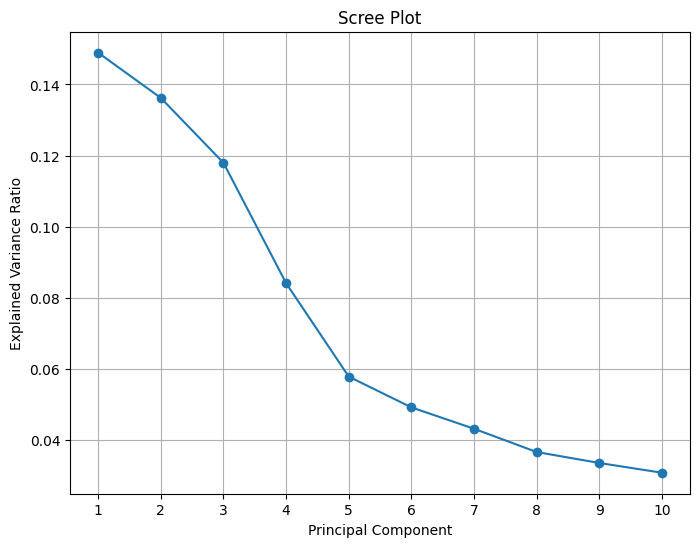

Cumulative Explained Variance: [0.14890594 0.28509365 0.40303959 0.48713938 0.54496353 0.59413261
 0.63729245 0.67390613 0.70743839 0.73822637]
Reconstruction Error: 4.914304003727143


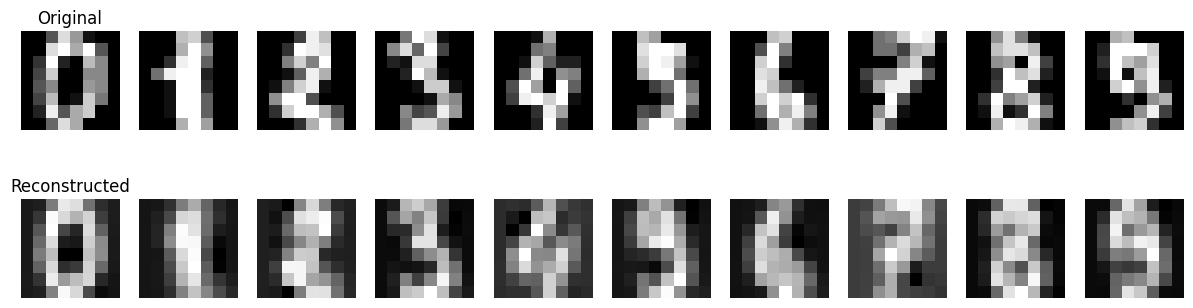

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.metrics import mean_squared_error

# Load example dataset (digits)
digits = load_digits()
X = digits.data
y = digits.target

# Perform PCA
n_components = 10  # Number of components to retain
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Plot scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, n_components + 1))
plt.grid(True)
plt.show()

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Reconstruction of the original data
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = mean_squared_error(X, X_reconstructed)
print("Reconstruction Error:", reconstruction_error)

# Visualize original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_reconstructed[i].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed')
plt.show()


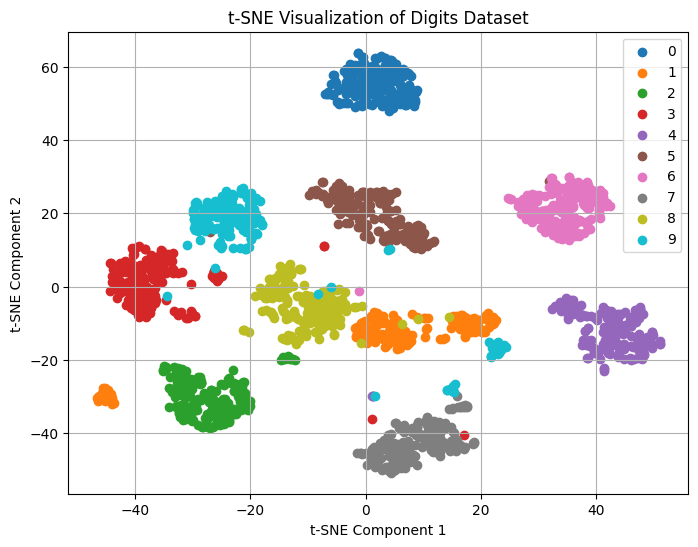

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Load example dataset (digits)
digits = load_digits()
X = digits.data
y = digits.target

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize the transformed data
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=str(i))
plt.title('t-SNE Visualization of Digits Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=3bff522e54986e7981171d957665ba21cd19a259dba474812f7a4881874d1548
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


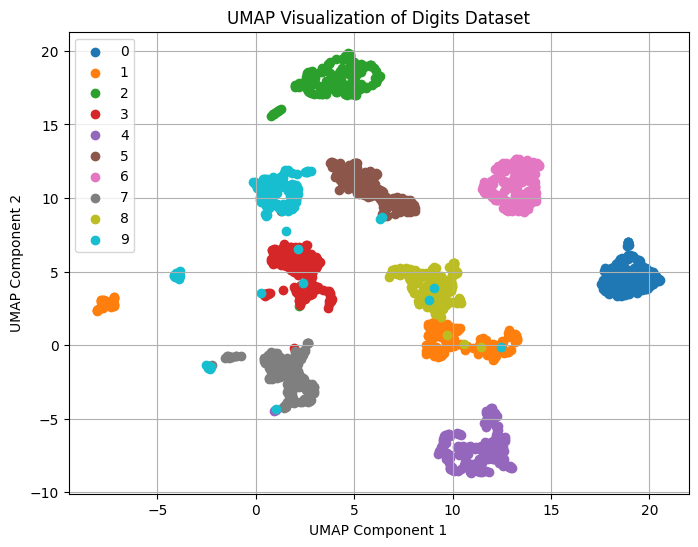

In [ ]:
!pip install umap-learn

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import load_digits

# Load example dataset (digits)
digits = load_digits()
X = digits.data
y = digits.target

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
X_umap = umap_model.fit_transform(X)

# Visualize the transformed data
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i))
plt.title('UMAP Visualization of Digits Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


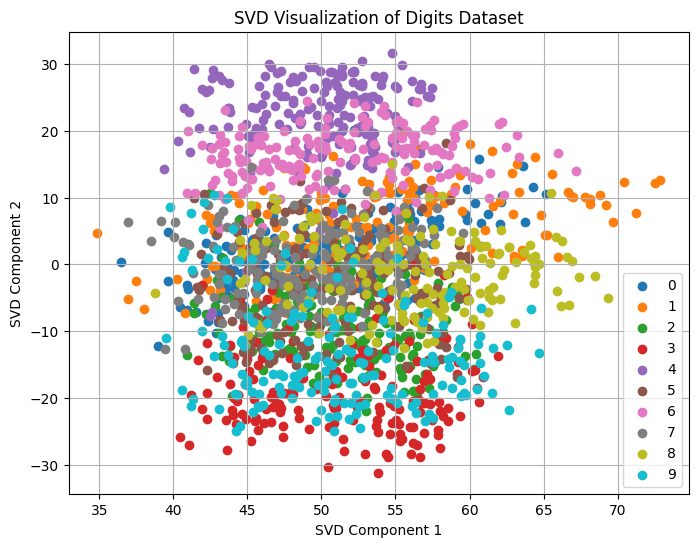

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import TruncatedSVD

# Load example dataset (digits)
digits = load_digits()
X = digits.data
y = digits.target

# Perform SVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

# Visualize the transformed data
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.scatter(X_svd[y == i, 0], X_svd[y == i, 1], label=str(i))
plt.title('SVD Visualization of Digits Dataset')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [31]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform K-means clustering on each partition
    n_clusters = 5  # You can adjust this number as needed
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_partition)

    # Take centroids from K-means clusters
    centroid = kmeans_model.cluster_centers_

    # Append the centroids to the list of centroids
    centroids.append(centroid)

# Concatenate the centroids along the samples axis to form dataset R
R = np.concatenate(centroids, axis=0)

# Ensure the dimensions of R and y are consistent
if len(R) != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")
else:
    print("Dimensions of R and y are consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

ValueError: Dimensions of R and y are not consistent.

In [35]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform K-means clustering on each partition
    n_clusters = 5  # You can adjust this number as needed
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_partition)

    # Take centroids from K-means clusters
    centroid = kmeans_model.cluster_centers_

    # Append the centroids to the list of centroids
    centroids.append(centroid)
# Concatenate the centroids along the samples axis to form dataset R
R = np.concatenate(centroids, axis=0)


# Ensure the dimensions of R and y are consistent
if len(R) != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")
else:
    print("Dimensions of R and y are consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

ValueError: Dimensions of R and y are not consistent.

In [38]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform K-means clustering on each partition
    n_clusters = 5  # You can adjust this number as needed
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_partition)

    # Take centroids from K-means clusters
    centroid = kmeans_model.cluster_centers_

    # Append the centroids to the list of centroids
    centroids.append(centroid)

# Concatenate the centroids along the samples axis to form dataset R
R = np.concatenate(centroids, axis=0)

# Ensure the dimensions of R and y are consistent
if R.shape[0] != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Get the minimum number of samples in any class
min_samples = min(np.bincount(y_train))

# Define the maximum number of splits to be less than or equal to the minimum number of samples
max_splits = min(5, min_samples - 1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=max_splits, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

ValueError: Dimensions of R and y are not consistent.

In [39]:
print("Shape of R:", R.shape)
print("Shape of y:", len(y))


Shape of R: (25, 784)
Shape of y: 70000


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform K-means clustering on each partition
    n_clusters = 5  # You can adjust this number as needed
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_partition)

    # Take centroids from K-means clusters
    centroid = kmeans_model.cluster_centers_

    # Append the centroids to the list of centroids
    centroids.append(centroid)

# Flatten and repeat centroids to match the length of y
centroids_flat = np.concatenate([centroid.flatten() for centroid in centroids])
R = np.repeat(centroids_flat[np.newaxis, :], len(y), axis=0)

# Ensure the dimensions of R and y are consistent
if R.shape[0] != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Initialize list to store centroids
centroids = []

# Perform K-means clustering on the entire dataset
n_clusters = 5  # You can adjust this number as needed
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(X)

# Take centroids from K-means clusters
centroids = kmeans_model.cluster_centers_

# Repeat centroids to match the length of y
R = np.repeat(centroids, len(X) // n_clusters, axis=0)

# Ensure the dimensions of R and y are consistent
if R.shape[0] != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model Accuracy: 0.11428571428571428


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X_scaled, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform K-means clustering on each partition
    n_clusters = 5  # You can adjust this number as needed
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(X_partition)

    # Take centroids from K-means clusters
    centroid = kmeans_model.cluster_centers_

    # Append the centroids to the list of centroids
    centroids.append(centroid)

# Flatten and repeat centroids to match the length of y
centroids_flat = np.concatenate([centroid.flatten() for centroid in centroids])
R = np.repeat(centroids_flat[np.newaxis, :], len(y), axis=0)

# Ensure the dimensions of R and y are consistent
if R.shape[0] != len(y):
    raise ValueError("Dimensions of R and y are not consistent.")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_rf_model.score(X_test, y_test)
print("Random Forest Model Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: Futur

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Split the dataset into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 60% train, 20% validation, 20% test

# Partition the training set into 3 partitions based on class label modulo 3
X_partitions = []
y_partitions = []
for i in range(3):
    X_partitions.append(X_train[y_train.astype(int) % 3 == i])
    y_partitions.append(y_train[y_train.astype(int) % 3 == i])

# Initialize lists to store results
accuracies = []
precisions = []
recalls = []

# Loop through each partition
for i, (X_partition, y_partition) in enumerate(zip(X_partitions, y_partitions)):
    # Split partition into train and test sets
    X_train_partition, X_test_partition, y_train_partition, y_test_partition = train_test_split(X_partition, y_partition, test_size=0.2, random_state=42)

    # Perform K-means clustering on the partition
    kmeans_model = KMeans(n_clusters=5, random_state=42)
    kmeans_model.fit(X_train_partition)
    centroids = kmeans_model.cluster_centers_

    # Initialize Decision Tree classifier
    dt_model = DecisionTreeClassifier()

    # Define hyperparameters to tune
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_partition, y_train_partition)

    # Get the best model
    best_dt_model = grid_search.best_estimator_

    # Evaluate on validation set
    y_val_pred = best_dt_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')

    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    # Print results
    print(f"Partition {i+1} - Validation Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Print overall results
print(f"\nOverall Results:")
for i in range(3):
    print(f"Partition {i+1} - Accuracy: {accuracies[i]}, Precision: {precisions[i]}, Recall: {recalls[i]}")


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Partition 1 - Validation Accuracy: 0.37064285714285716, Precision: 0.1649557502914141, Recall: 0.37064285714285716


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Partition 2 - Validation Accuracy: 0.30457142857142855, Precision: 0.10434441052042275, Recall: 0.30457142857142855


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Partition 3 - Validation Accuracy: 0.26485714285714285, Precision: 0.07658278542331251, Recall: 0.26485714285714285

Overall Results:
Partition 1 - Accuracy: 0.37064285714285716, Precision: 0.1649557502914141, Recall: 0.37064285714285716
Partition 2 - Accuracy: 0.30457142857142855, Precision: 0.10434441052042275, Recall: 0.30457142857142855
Partition 3 - Accuracy: 0.26485714285714285, Precision: 0.07658278542331251, Recall: 0.26485714285714285


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

# Partition the data into multiple subsets
num_partitions = 5
X_partitions = np.array_split(X, num_partitions)
y_partitions = np.array_split(y, num_partitions)

# Initialize list to store centroids
centroids = []

# Loop through each partition
for X_partition, y_partition in zip(X_partitions, y_partitions):
    # Perform KNN on each partition to find the nearest neighbors
    n_neighbors = 5
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_partition, y_partition)
    distances, indices = knn_model.kneighbors(X_partition)

    # Calculate the centroid from each set of nearest neighbors
    centroid = np.mean(X_partition[indices], axis=1)

    # Append the centroid to the list of centroids
    centroids.append(centroid)

# Stack the centroids to form dataset R
R = np.vstack(centroids)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(R, y, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model
accuracy = best_dt_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Model Accuracy: 0.9137857142857143
